In [1]:
library(pracma)
library(plotly)
library(matrixcalc)
library(viridis)
library(fields)
library(Matrix)
library(clusterGeneration)
#library(wordspace)
#load source file
src.path <- "../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utlity.R", sep="/"))
source(paste(src.path, "Estimation", "cca_estimation.R", sep="/"))

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: ‘Matrix’


The following object is masked from ‘package:spam’:

    det


The following objec

In [2]:
install.packages('clusterGeneration')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages('plotly')
install.packages('wordspace')
install.packages('R.matlab')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘sparsesvd’, ‘iotools’


Warning message in install.packages("wordspace"):
“installation of package ‘wordspace’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
n <- 100
p <- 50
k.gen <- 9
M <- 2
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(9,9)

Apinv_list <- list()
A_list <- list()
N_list <- list()
basis.m_list <- list()
true.basis_list <- list()
true.values_list <- list()

In [4]:
perm <- function(n){ 
    x = 1:n 
    k = n  
    out = NULL
    while(k>0){
    if(length(x)>1){
        y = sample(x, size=1) 
    }else{
        y = x
    }
    
    out = c(y,out)
    x = setdiff(x,out)
    k = k-1 
    }
    out
}

[1] 9 9
[1] 0.56 0.52 0.48 0.44 0.40 0.36 0.32 0.28 0.24
[1] "max eigen A 27.641631452671 min eigen A -7.14701475451323"
[1] "min difference (ratio) 7.68585081108449e-11"
[1] "max difference (ratio) 0.463161551225124"


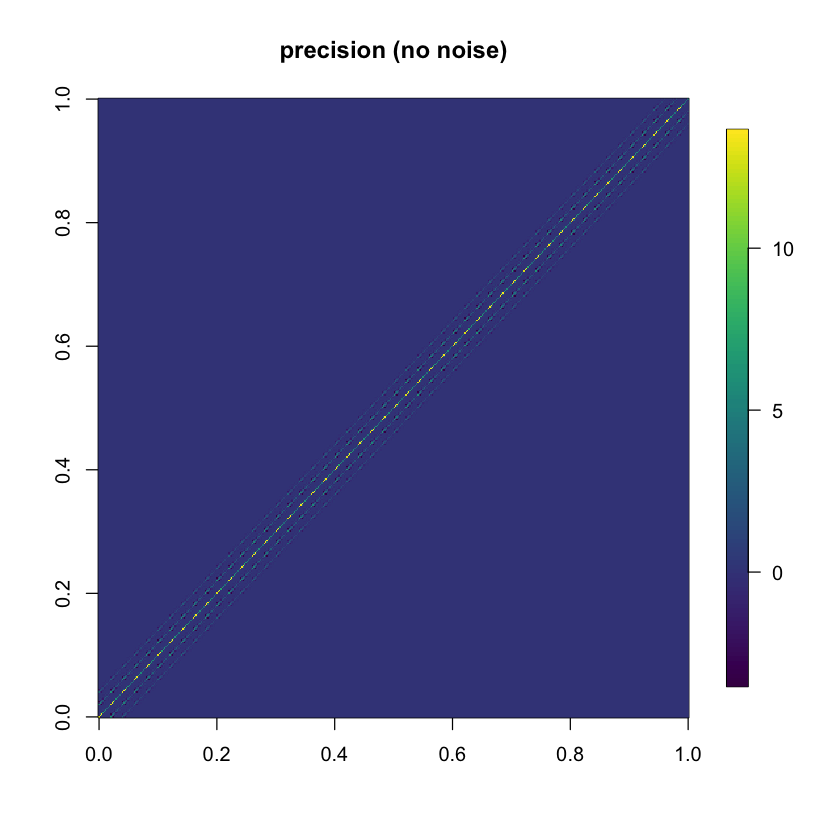

[1] 9 9
[1] 0.56 0.52 0.48 0.44 0.40 0.36 0.32 0.28 0.24
[1] "max eigen A 27.6416314526709 min eigen A -7.14701475451322"
[1] "min difference (ratio) 4.14429656093131e-11"
[1] "max difference (ratio) 0.552302394763125"


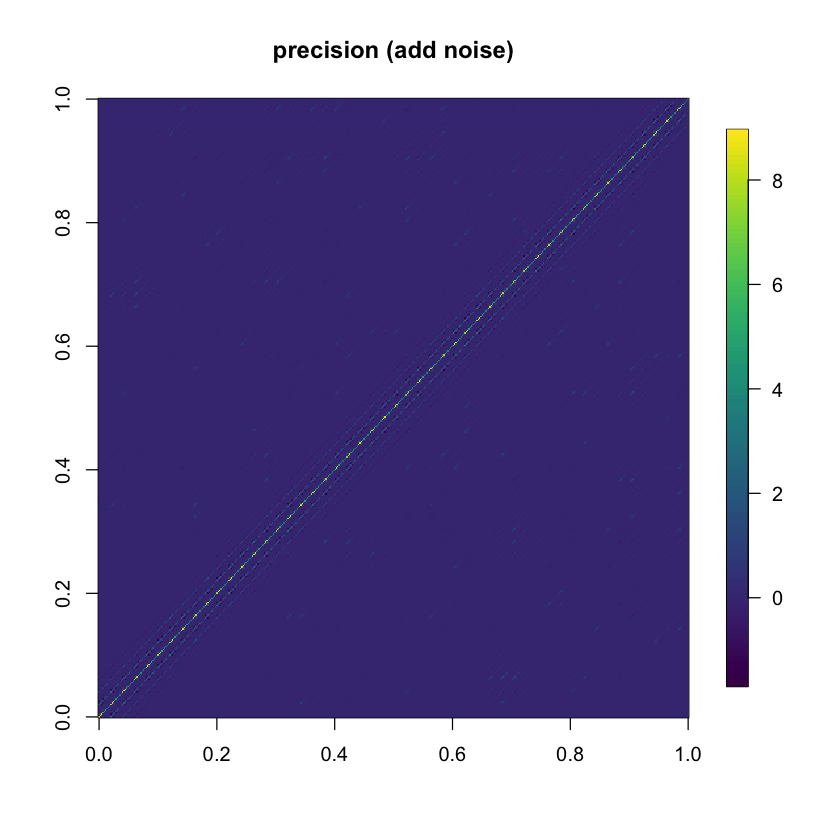

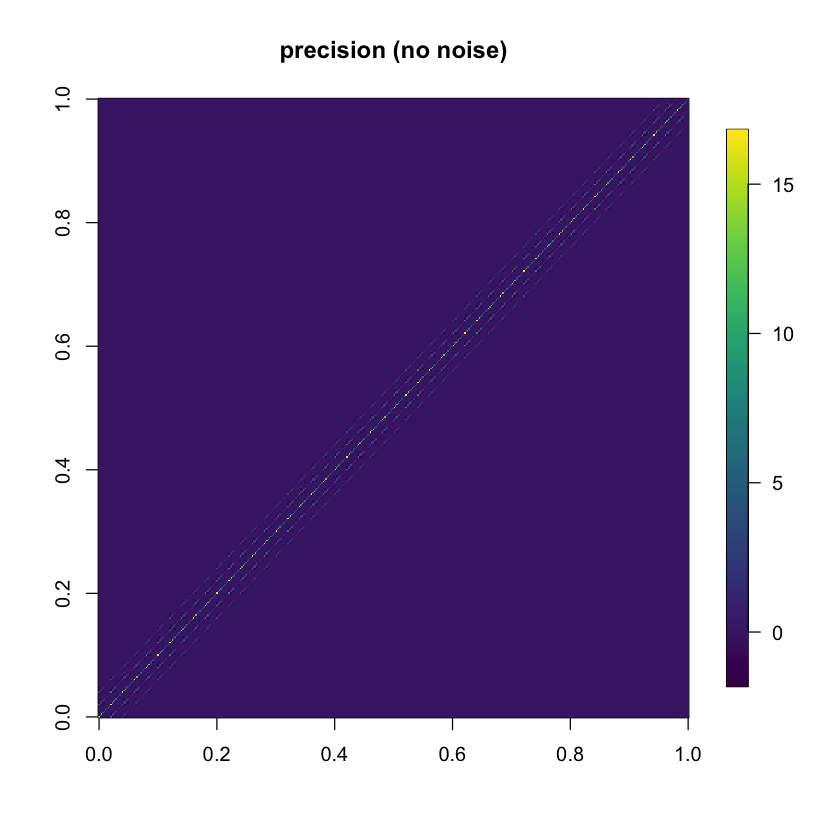

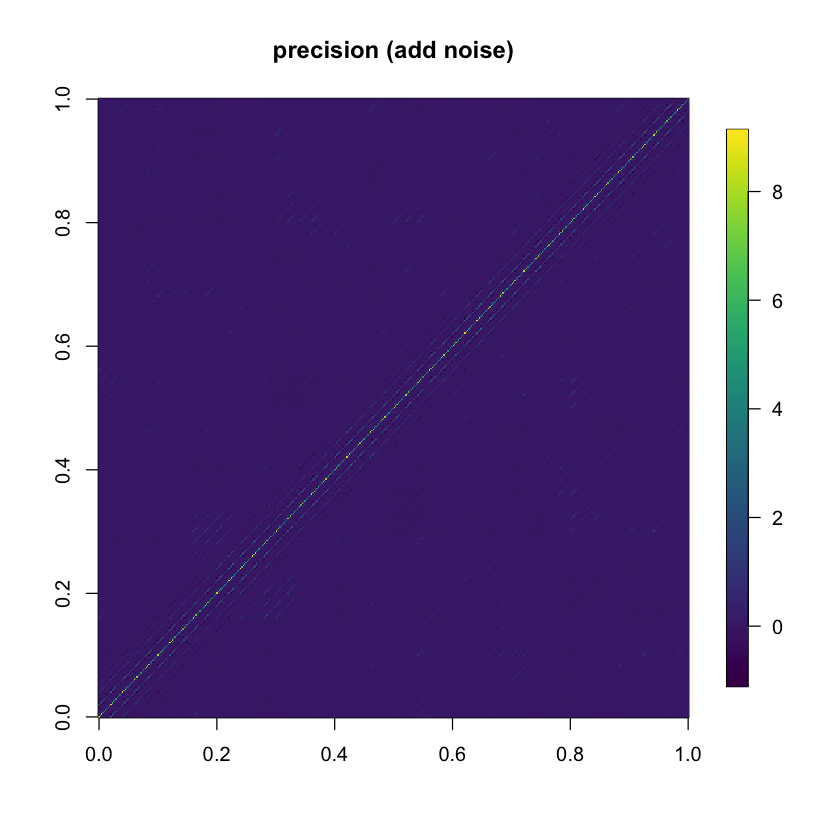

[1] "min difference 2.08758936805924e-09"
[1] "max difference 2.69107675003384"


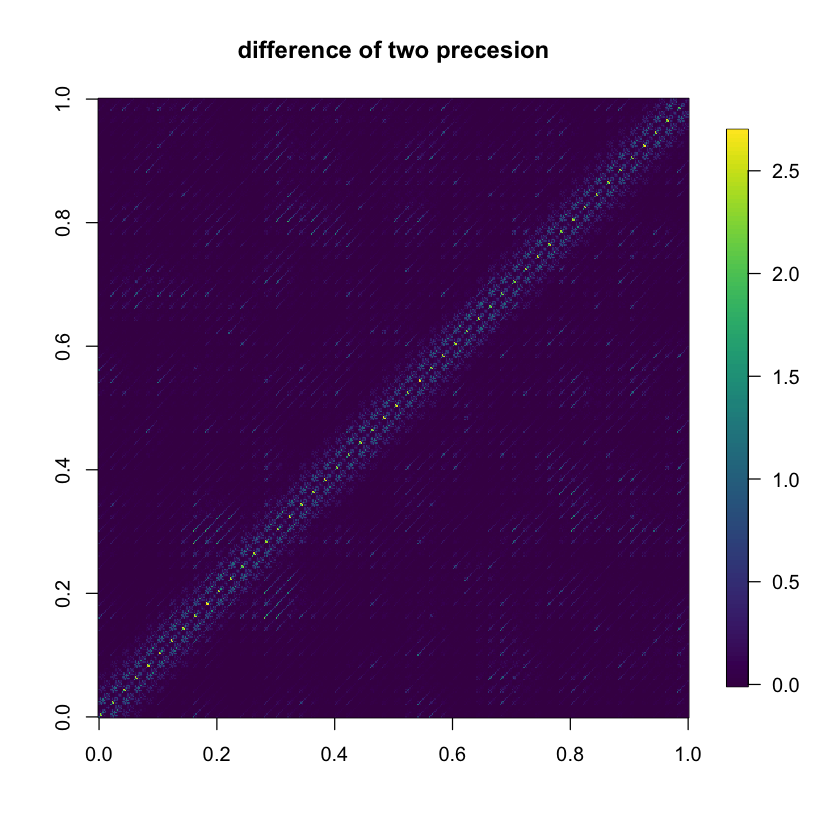

In [11]:
#generate data from the graph

omega <- synth.omega.tridiag1(p, k.gen)#, drop=0.1)
#ensure that the diagonal values are all 1

cov <- solve(omega)


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen, km.gen[m], 3, scale=.2)
    Am <- t(t(Am) %*% diag(.2*((1:k.gen))+1)) #this is to make the singular values distinct
    print(dim(Am))
    A_list[[m]] <- Am
    Am_svd <- svd(Am)
    id <- which(Am_svd$d > 1e-5)
    print(Am_svd$d)
    Am_inv <- t(Am_svd$u[,id] %*% diag(Am_svd$d[id]) %*% t(Am_svd$v[,id]))
    Apinv_list[[m]] <- Am_inv
    
    #par(bg="white")
    #image.plot(Am_inv,col=viridis(128) )
    
    Acov <- kronecker(diag(p), Am_inv) %*% cov %*% t(kronecker(diag(p),Am_inv))
    eig_A <- eigen(Acov, symmetric = TRUE)
    min_eigA <- min(eig_A$values)
    max_eigA <- max(eig_A$values)
    N_list[[m]] <- diag(p*km.gen[m])*.1
    print(paste("max eigen A", max_eigA, "min eigen A", min_eigA))
    
    density = 0.05*m
    
    x <- rsparsematrix(p, p, density, 
              symmetric = FALSE)
              
    y <- as.matrix((x+t(x))/2)
    y2 <- t(matrix(rep(y, each=km.gen[m]), ncol=p))
    y3 <- t(matrix(rep(y2, each=km.gen[m]), ncol= p*km.gen[m]))
    y3 <- matrix(0,p*km.gen[m], p*km.gen[m])
    for(i in 1:p){
        for(j in 1:km.gen[m]){
            idx = seq(1,km.gen[m]*p, km.gen[m]) + (j-1)
            y3[(i-1)*km.gen[m]+j, idx] <- y[i,]
        }
    }
    eig_y <- eigen(y3, symmetric = TRUE) 
    id <- which(eig_y$values > 1e-5)
    #print(paste("rank:",length(id)))
    #compute the pqsudo inverse
    #set.seed(5)

    #noise_cov <- noise_cov - diag(p*km.gen[m])*max(diag(noise_cov))
    x<- synth.linear_op.sparse_orthogonal(p*km.gen[m], p*km.gen[m], num_block=max(p/10, 3), scale=1)

    noise_cov <- solve(synth.omega.random(p, km.gen[m], drop=0.05))
    noise_y <- eigen(noise_cov, symmetric = TRUE)
    new_values <- (noise_y$values) / max(noise_y$values) * max_eigA*0.01
    N_list[[m]]  <- noise_y$vectors %*% diag(new_values) %*% t(noise_y$vectors)
    
     # + diag(p*km.gen[m])*.1

    basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])

    eigen.r <- synth.true.basis(obs.time, cov[1:k.gen,1:k.gen], Apinv_list[[m]], basis.m_list[[m]])
    true.basis_list[[m]] <- eigen.r$vectors
    true.values_list[[m]] <- eigen.r$values 

    
    if(m == 1){
        pre1 <- solve(Acov+N_list[[m]])
    }

    pre <- pinv(Acov+N_list[[m]])

    #par(bg="white")
    #image.plot(Acov ,col=viridis(128), main='covariance without noise mtrix')   
    true <- pinv(Acov)
    max_div <- max(pre,true)

    #par(bg="white")
    #image.plot(abs(pinv(Acov)-solve(Acov+N_list[[m]]))/max_div ,col=viridis(128), main='precision (difference)')
    print(paste("min difference (ratio)", min(abs(pre-true))/max_div))
    print(paste("max difference (ratio)", max(abs(pre-true))/max_div))
    par(bg='white')
    image.plot(solve(Acov) ,col=viridis(128), main='precision (no noise)')
    par(bg='white')
    image.plot(solve(Acov+N_list[[m]]) ,col=viridis(128), main='precision (add noise)')
    
}
par(bg="white")
image.plot(abs(pre1-solve(Acov+N_list[[m]])), col=viridis(128), main='difference of two precesion')
print(paste("min difference", min(abs(pre1-solve(Acov+N_list[[m]])))))
print(paste("max difference", max(abs(pre1-solve(Acov+N_list[[m]])))))

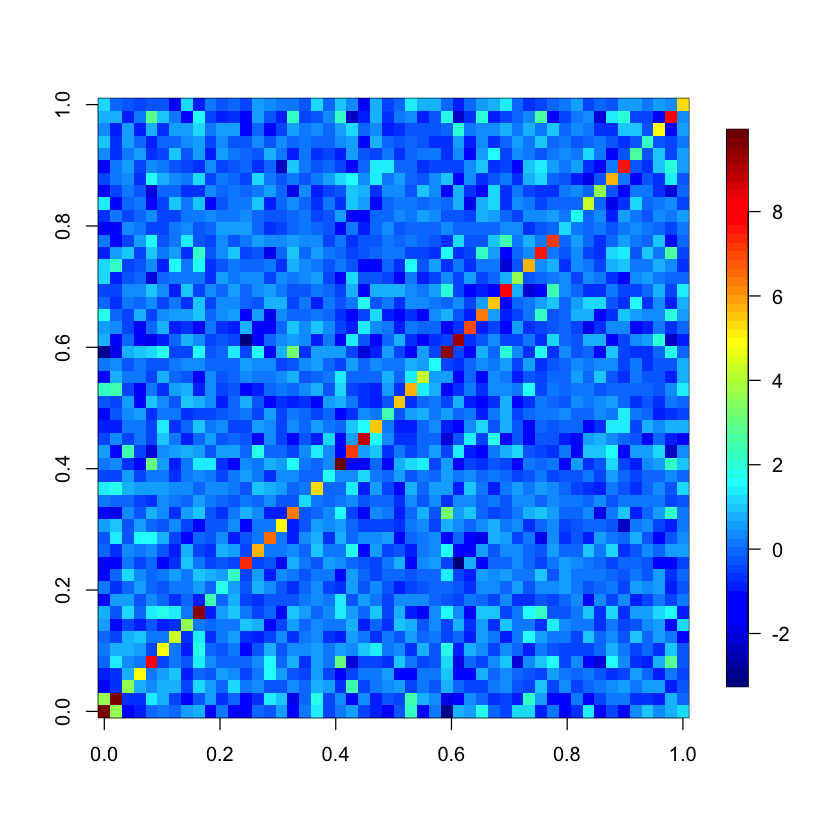

In [84]:
image.plot(genPositiveDefMat(
		  dim = 50, 
		  covMethod =  "onion")$Sigma)

In [ ]:
eig_y <- eigen(y,symmetric = TRUE) 
which[eig_y]

In [56]:
(x %*% t(x)) *0.05

45 x 45 sparse Matrix of class "dgCMatrix"
                                                                               
 [1,]  0.06050  .           .         .          .         .          .        
 [2,]  .        0.65921245  .        -0.0036550  0.111425  .          0.1246750
 [3,]  .        .           0.095085  .          0.009900  .          .        
 [4,]  .       -0.00365500  .         0.1663809  0.002365  0.0045150  0.0004875
 [5,]  .        0.11142500  0.009900  0.0023650  0.156705  0.1155000  0.0810000
 [6,]  .        .           .         0.0045150  0.115500  0.4714813  .        
 [7,]  .        0.12467500  .         0.0004875  0.081000  .          0.6492263
 [8,]  .        .           .         .          0.002888  0.0285000  0.1012000
 [9,]  .       -0.07900000  .         0.0016555  0.042350  0.0872250  .        
[10,] -0.00264  .           .         .          .        -0.0045000  0.0064000
[11,]  .        .           .         .          .         .         -0.16000

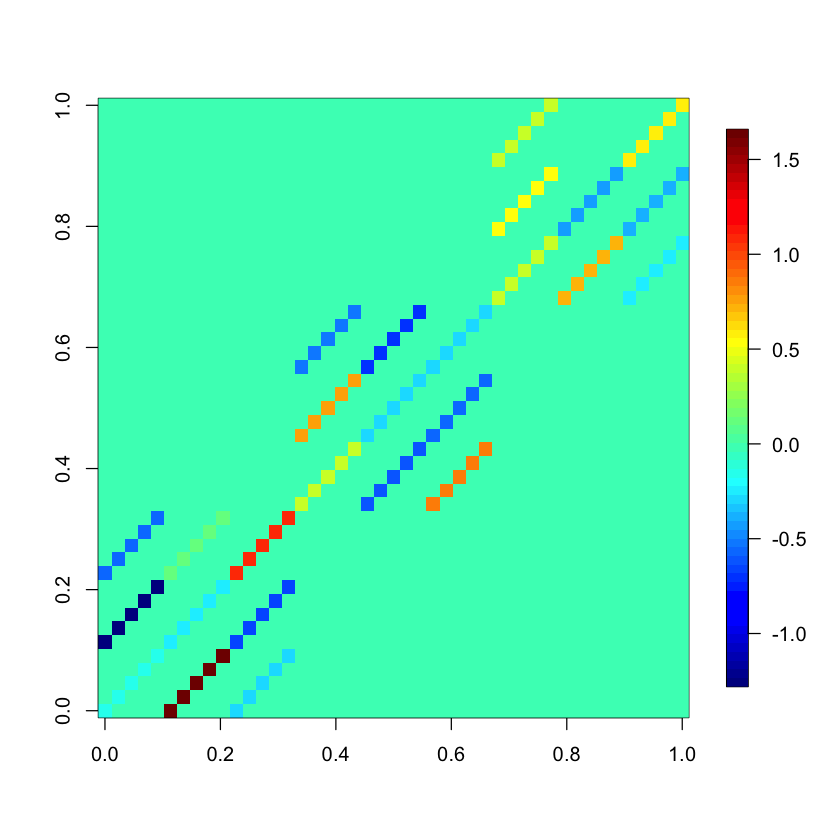

In [54]:
rowNorms(A_list[[1]])
rowNorms(A_list[[2]])

ERROR: Error in rowNorms(A_list[[1]]):  関数 "rowNorms" を見つけることができませんでした 


In [55]:

source(paste(src.path, "Utility", "R2python.R", sep="/"))

In [56]:
k <- 9
lar <- 0

for(j in 1:(p-1)){
    lar <- max(norm(B_list[[1]][, ((j-1)*k+1):(j*k)]),lar)
}
print(lar)


[1] 1


In [57]:
#convert to regression B
B_list <- utility.graph2B(omega,p)

utlity.save_graphs(A_list,B_list, thre=1e-2, "../data",  "random")
load("../data/random.RData")

[1] 9

  0   1   2   3   4   5 
184 268 356 530 478 634 
[1] "sparsity: 26"
[1] "alpha: 7"
[1] "Finish saving graphs"


In [107]:

print(eigen(Acov, symmetric=TRUE)$values)
inv_cov = solve(Acov)
est.r <- eigen(inv_cov, symmetric=TRUE)
inv_cov1.s <- est.r$vectors %*% diag(sqrt(est.r$values)) %*% t(est.r$vectors)
print(eigen(inv_cov1.s, symmetric=TRUE)$values)

inv_cov = solve(Acov)
est.r <- eigen(Acov, symmetric=TRUE)
inv_cov1.s <- est.r$vectors %*% diag(1./sqrt(est.r$values)) %*% t(est.r$vectors)
print(eigen(inv_cov1.s, symmetric=TRUE)$values)




 [1] 2.7777778 2.0408163 1.5625000 1.2345679 1.0000000 0.8264463 0.6944444
 [8] 0.5917160 0.5102041 0.4444444 0.3906250
 [1] 1.6 1.5 1.4 1.3 1.2 1.1 1.0 0.9 0.8 0.7 0.6
 [1] 1.6 1.5 1.4 1.3 1.2 1.1 1.0 0.9 0.8 0.7 0.6


In [117]:
n <- 1000
data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list,N_list, dependent=TRUE, addnoise=FALSE)
fbasis_list <- list()
fvalue_list <- list()
cov_list <- list()
#only select one dimension to compute the basis
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    est.r <- estimate.fpca.basis(c(0,1), obs.time, t(data[[m]][,1,]), km.gen[m], bs.nbasis=km.gen[m]*3)
    fbasis_list[[m]] <- est.r$vectors

    fvalue_list[[m]] <- est.r$values[1:km.gen[m]]

    est.r <- estimate.fpca.sum.basis(c(0,1), obs.time, data[[m]][,1,], km.gen[m], bs.nbasis=km.gen[m]*3)
    cov_list[[m]] <- est.r$cov
}

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"


[1] "done"

[1] "done"

[1] "done"

[1] "done"

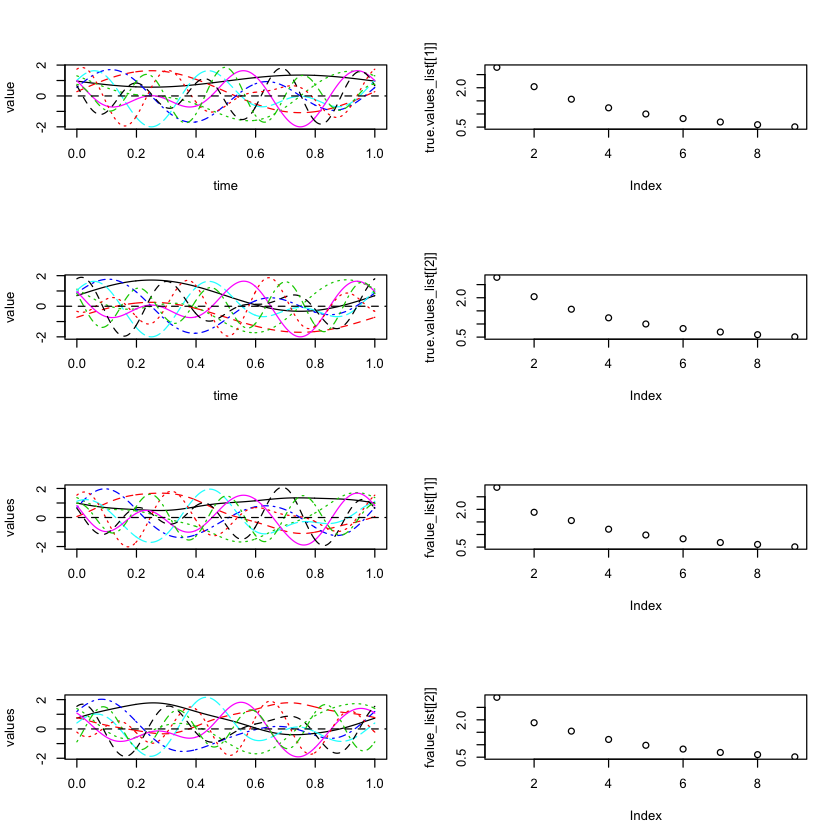

In [118]:
par(bg="white",mfrow=c(4,2))
plot(true.basis_list[[1]])


plot(true.values_list[[1]])


plot(true.basis_list[[2]])


plot(true.values_list[[2]])


plot(fbasis_list[[1]])

plot(fvalue_list[[1]])

plot(fbasis_list[[2]])

plot(fvalue_list[[2]])




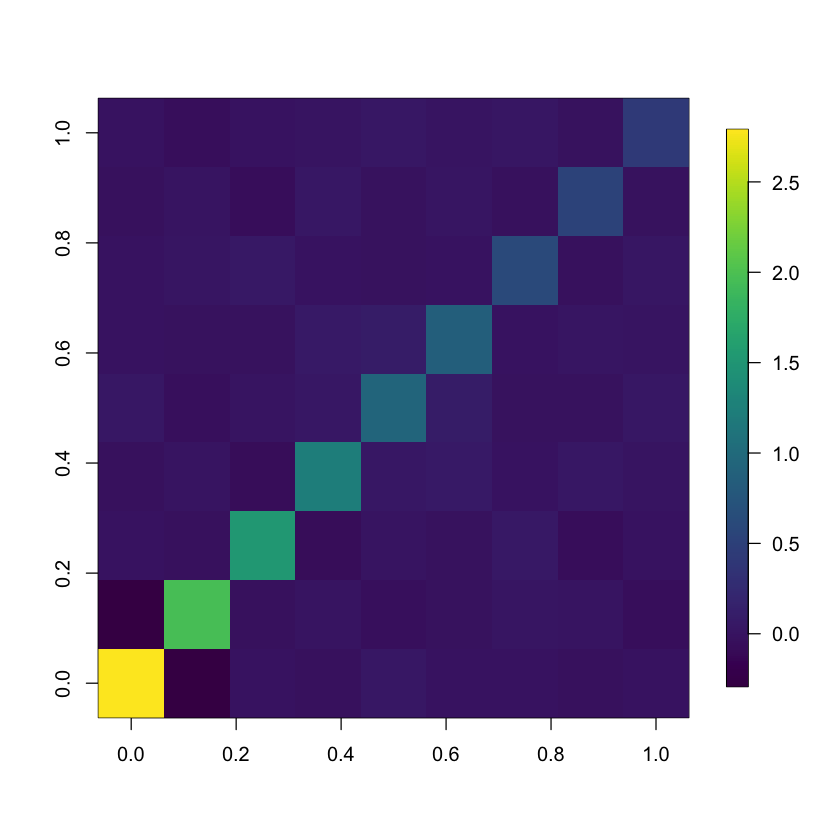

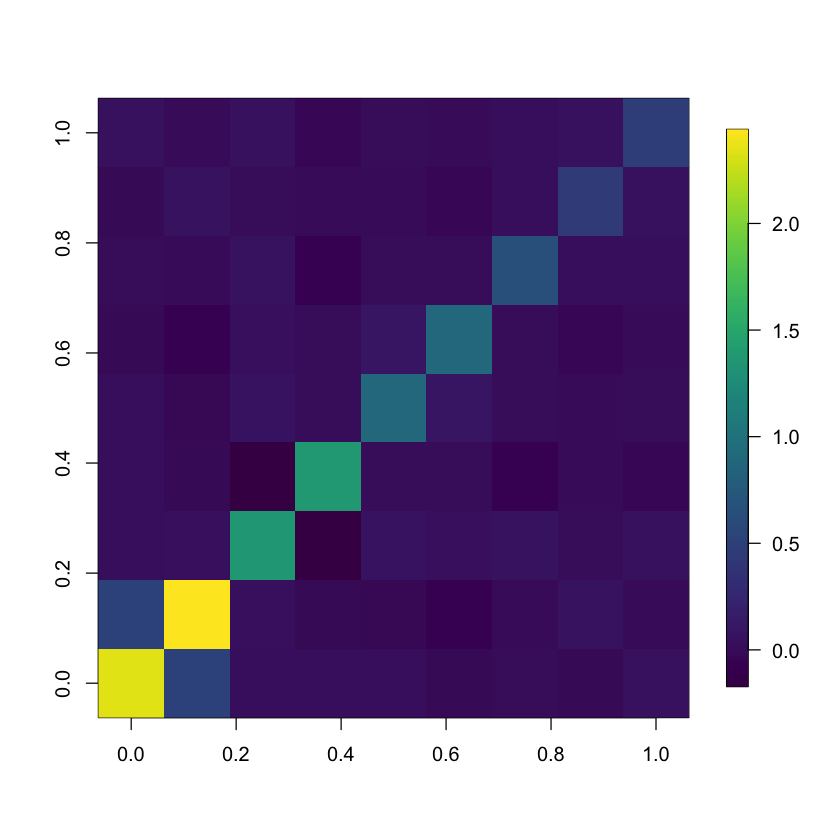

In [119]:
par(bg="white")
image.plot(cov_list[[1]],col=viridis(256))
par(bg="white")
image.plot(cov_list[[2]],col=viridis(256))

#### Basis expansion method

In [120]:
estimate.cca.basis_expansion <- function(obj1, obj2, ncan){
    #obj, obj2:fd object
    stopifnot(dim(obj1$coefs)[2] == dim(obj2$coefs)[2])
    n <- dim(obj1$coefs)[2]
    #d1 <- obj1$coefs#t(inprod(obj1, obj1$basis))
    #d2 <- obj2$coefs#t(inprod(obj2, obj2$basis))

    d1 <- t(inprod(obj1, obj1$basis))
    d2 <- t(inprod(obj2, obj2$basis))
    cov1  <- (d1 %*% t(d1)) / n
    cov2  <- (d2 %*% t(d2)) / n
   
    cov12 <- (d1 %*% t(d2)) / n

    
    inv_cov1.s <- solve( cov1 )

    #inv_cov1.s <- solve( cov1 )
    est.r <- eigen(inv_cov1.s , symmetric=TRUE)
    
    inv_cov1.s <- est.r$vectors %*% diag(sqrt(est.r$values)) %*% t(est.r$vectors)



    inv_cov2.s <- solve( cov2 )

    est.r <- eigen(inv_cov2.s,  symmetric=TRUE)
    inv_cov2.s <- est.r$vectors %*% diag(sqrt(est.r$values)) %*% t(est.r$vectors)
    
    
    m <- (inv_cov1.s %*% cov12) %*% inv_cov2.s
    m <- m %*% t(m)
    
    eigen.m <- eigen(m, symmetric=TRUE)
    corr <- diag(1. / sqrt(eigen.m$values))
    print(diag(corr))

    A1 <- inv_cov1.s  %*% eigen.m$vectors %*% corr
    
    A2 <- inv_cov2.s %*% inv_cov2.s %*% t(cov12) %*% A1 

    return(list("A1"=t(A1), "A2"=t(A2)))

}

In [121]:
km.gen

[1] 9 9

[1] 1.003530 1.004875 1.006539 1.008702 1.009396 1.010735 1.014225 1.016567
[9] 1.020744


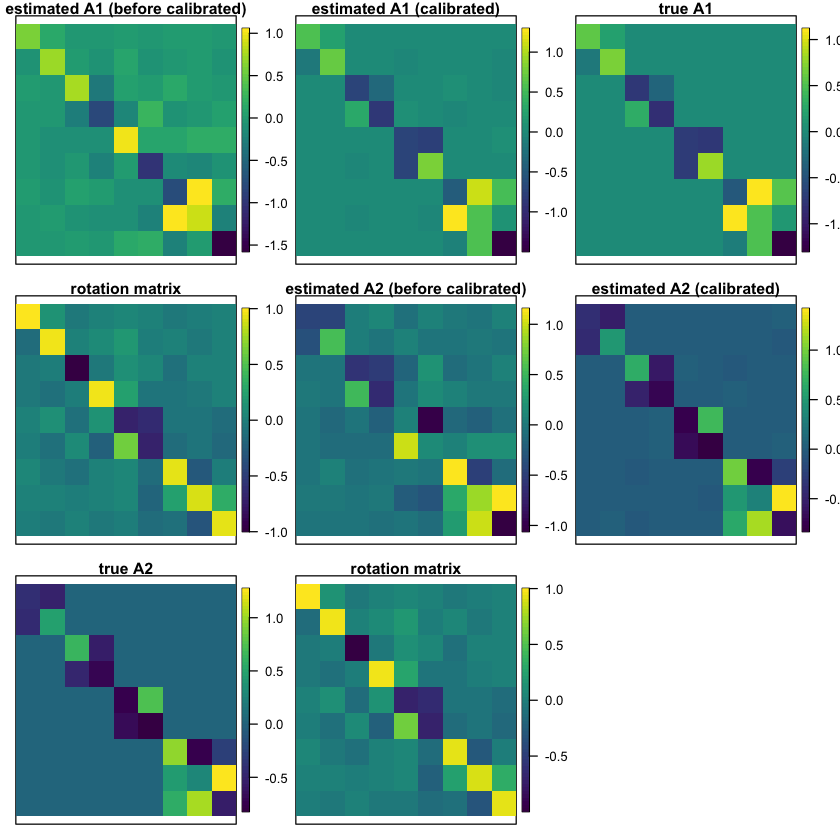

In [122]:
#data modality 1

fourier.basis1 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[1])

concate_data <- list()
for(m in 1:M){
        dm <- data[[m]][,1,]
    for(i in 2:p){
        dm <- rbind(dm, data[[m]][,p,])
    }
    concate_data[[m]] <- dm
}

#d1 <-Data2fd(argvals=obs.time, y=t(concate_data[[1]]), basisobj=fourier.basis1)
d1 <-Data2fd(argvals=obs.time, y=t(data[[1]][,1,]), basisobj=fourier.basis1)
#data modality 2
fourier.basis2 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[2])
#d2 <-Data2fd(argvals=obs.time, y=t(concate_data[[2]]), basisobj=fourier.basis2)
d2 <-Data2fd(argvals=obs.time, y=t(data[[2]][,1,]), basisobj=fourier.basis2)


cca.r.est <- estimate.cca.basis_expansion(d1, d2, km.gen[1])
par(bg="white", mfrow=c(3,3),mar=c(1,1,1,1))

tempR <- A_list[[1]] %*% t(cca.r.est$A1)
svd.r <- svd(tempR)
R <- svd.r$u %*% t(svd.r$v)

image.plot( cca.r.est$A1, ylim=c(1.1,-0.1), col=viridis(64),xaxt='n',yaxt='n', main="estimated A1 (before calibrated)")


max_val = max(cca.r.est$A1, A_list[[1]]) + 1
min_val = min(cca.r.est$A1, A_list[[1]]) - 1
lim = max(max_val,abs(min_val))

image.plot(R %*% cca.r.est$A1, ylim=c(1.1,-0.1),col=viridis(64),xaxt='n',yaxt='n', main="estimated A1 (calibrated)")

image.plot(A_list[[1]], col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n',   main="true A1")
image.plot(R, col=viridis(64),ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="rotation matrix")


tempR <- A_list[[2]] %*% t(cca.r.est$A2)
svd.r <- svd(tempR)
R <- svd.r$u %*% t(svd.r$v)

image.plot(cca.r.est$A2, col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="estimated A2 (before calibrated)")

image.plot(R%*%cca.r.est$A2, col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="estimated A2 (calibrated)")
image.plot(A_list[[2]], col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n',   main="true A2")
image.plot(R, col=viridis(64),ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="rotation matrix")
#cca.r.est<- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.gen)
#print("cca correlation")
#print(cca.r.est$corr)


In [20]:
rowNorms(cca.r.est$A1)
rowNorms(cca.r.est$A2)

ERROR: Error in rowNorms(cca.r.est$A1):  関数 "rowNorms" を見つけることができませんでした 


In [49]:
##save data 
est_A <- list()
est_A[[1]] <- cca.r.est$A1
est_A[[2]] <- cca.r.est$A2 
X_score <- list()
basis_list <- list()
basis_list[[1]] <- fourier.basis1
basis_list[[2]] <- fourier.basis2
for (m in 1:M){
    data.arr <- array(data = NA, dim = c(n,p,km.gen[[1]]), dimnames = NULL)
    for(i in 1:p){
        obj <- Data2fd(argvals=obs.time, y=t(data[[m]][,i,]), basisobj=basis_list[[m]] )
        data.arr[,i,] <- t(obj$coefs)
    }
    X_score[[m]] <- data.arr
}



In [22]:
utility.save_data(est_A, X_score, "../data", "data3")

ERROR: Error in paste(path, "/", filename, ".RData", sep = ""):  引数 "filename" がありませんし、省略時既定値もありません 


In [23]:
dim( d1$coefs)

[1]     9 50000

#### fPCA based method

In [50]:
#data modality 1

bspline.basis1 <- create.bspline.basis(rangeval=c(0,1), nbasis=3*km.gen[1])

d1 <-Data2fd(argvals=obs.time, y=t(data[[1]][,1,]), basisobj=fbasis_list[[1]])
#data modality 2
bspline.basis2 <- create.bspline.basis(rangeval=c(0,1), nbasis=3*km.gen[2])
d2 <-Data2fd(argvals=obs.time, y=t(data[[2]][,1,]), basisobj=fbasis_list[[2]])

cca.r.est<- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.gen)
print("cca correlation")
print(cca.r.est$corr)


[1] "cca correlation"
[1] 1.0001491 0.9940363 0.9898806 0.9873753 0.9848734 0.9820769 0.9798116
[8] 0.9693148 0.9687489


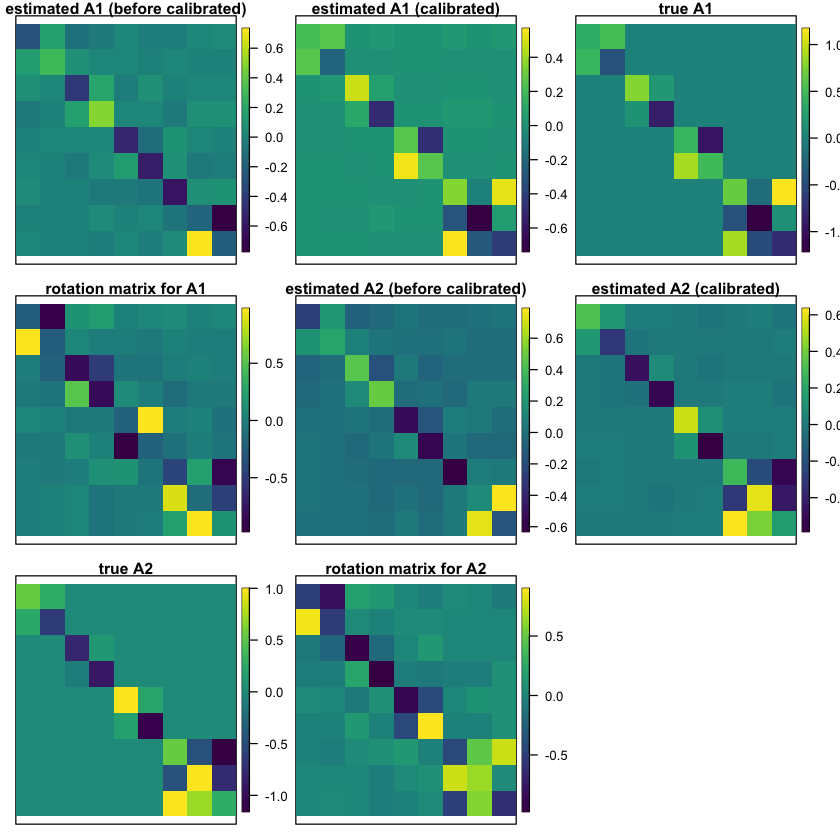

In [53]:


tempR <- A_list[[1]] %*% t(cca.r.est$A1)
svd.r <- svd(tempR)
R <- svd.r$u %*% t(svd.r$v)


par(bg="white", mfrow=c(3,3),mar=c(1,1,1,1))

image.plot(cca.r.est$A1, col=viridis(64), ylim=c(1.1,-0.1), xaxt='n',yaxt='n', main="estimated A1 (before calibrated)")
image.plot(R %*% cca.r.est$A1, col=viridis(64), ylim=c(1.1,-0.1), xaxt='n',yaxt='n', main="estimated A1 (calibrated)")
image.plot(A_list[[1]], col=viridis(64), ylim=c(1.1,-0.1), xaxt='n',yaxt='n',  main="true A1")

image.plot(R,col=viridis(64), ylim=c(1.1,-0.1), xaxt='n',yaxt='n', main="rotation matrix for A1")

max_val = max(cca.r.est$A2, A_list[[2]]) + 1
min_val = min(cca.r.est$A2, A_list[[2]]) - 1
lim = max(max_val,abs(min_val))
#image.plot(cca.r.true$A2, col=viridis(64))

tempR <- A_list[[2]] %*% t(cca.r.est$A2)
svd.r <- svd(tempR)
R <- svd.r$u %*% t(svd.r$v)


image.plot( cca.r.est$A2, col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="estimated A2 (before calibrated)")
image.plot( R %*% cca.r.est$A2, col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="estimated A2 (calibrated)")
image.plot(A_list[[2]], col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n',  main="true A2")
image.plot(R,col=viridis(64), ylim=c(1.1,-0.1),xaxt='n',yaxt='n', main="rotation matrix for A2")



par(bg="white", mfrow=c(2,2))




In [34]:
## save data to python 


## save graph to python 

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
